# RAG & LLM Evaluation Tutorial (Beginner → Intermediate)

This notebook walks through **core evaluation ideas** you’ll see in real-world Retrieval-Augmented Generation (RAG) and LLM systems:

- How to measure **retrieval quality** (Are we fetching the right documents?)
- How to measure **similarity** between texts (using **TF‑IDF + cosine similarity**)
- How to approximate **answer quality** with a simple overlap metric

> 🎯 **Goal:** By the end, you should be able to read evaluation tables like *Recall@k, Precision@k, similarity scores,* and understand what they mean and how to compute them in Python.


## 1. What is RAG and Why Do We Evaluate?

**Retrieval‑Augmented Generation (RAG)** =

> Use a **retriever** to fetch relevant documents → feed them into an **LLM** → generate an answer that is grounded in those docs.

There are **two big pieces** to evaluate:

1. 🔎 **Retrieval** – did we fetch the *right* context?
   - If retrieval is bad, even a great LLM will hallucinate or guess.

2. 🧠 **Generation (LLM answers)** – did the model:
   - Use the retrieved information?
   - Answer the actual question correctly?
   - Avoid hallucinations?

In this notebook, we’ll build a **tiny, synthetic RAG setup** and focus on:

- Retrieval metrics: **Recall@k, Precision@k**
- Similarity scores: **TF‑IDF + cosine similarity**
- Simple answer quality: **word overlap score**


In [1]:
# Core imports
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd

# Text / retrieval utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Optional visualization
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 4)

print("✅ Imports ready.")

✅ Imports ready.


## 2. Tiny Synthetic RAG Dataset

To keep things **simple and visible**, we’ll build a tiny “doc + query” set in memory.

- 5 documents (our *knowledge base*)
- 3 user queries
- For each query we define:
  - Which docs are **truly relevant** (our *ground truth*)
  - A **gold answer** (what a perfect assistant would say)
  - A **model answer** (what our pretend LLM answered)

In real systems, these would come from logs, annotation pipelines, or labeling tools.


In [2]:
# Our tiny "corpus" of documents (knowledge base)
documents = [
    "RAG systems combine retrieval and generation using large language models.",
    "TF-IDF is a classic method to turn documents into numerical vectors based on word frequency.",
    "Vector databases store embeddings and let you search by semantic similarity.",
    "Precision and recall are standard information retrieval metrics used to evaluate search quality.",
    "Evaluation of LLMs often includes answer correctness, grounding, and hallucination analysis."
]

# Give each doc an ID for reference
doc_ids = list(range(len(documents)))

# Our tiny set of user questions (queries)
queries = [
    "How do RAG systems work?",
    "What is TF-IDF in information retrieval?",
    "How do we evaluate search with precision and recall?",
]

# For each query, define the doc indices that we consider truly relevant
ground_truth_relevant = {
    0: [0, 4],   # RAG question: docs 0 and 4 are relevant
    1: [1],      # TF-IDF question: doc 1 is relevant
    2: [3],      # precision/recall question: doc 3 is relevant
}

# Optional: gold answers (ideal) and model answers (simulated)
gold_answers = {
    0: "A RAG system retrieves relevant documents and feeds them into an LLM to generate grounded answers.",
    1: "TF-IDF is a way to score words by how frequent they are in a document versus across the whole corpus.",
    2: "Search is evaluated by precision and recall, which look at how many retrieved results are relevant and how many relevant results were retrieved."
}

model_answers = {
    0: "RAG uses search plus a language model. It looks up context and then the LLM uses it to answer.",
    1: "In TF-IDF, terms that appear often in a document but not everywhere get higher scores.",
    2: "Precision and recall are metrics. Precision is about retrieved relevant things, recall is about how much you got."
}

print("Number of documents:", len(documents))
print("Number of queries:", len(queries))

Number of documents: 5
Number of queries: 3


## 3. Retrieval Metrics: Recall@k and Precision@k

When we ask a question, the retriever returns a ranked list of documents.

Two **very common metrics** are:

### 🔁 Recall@k (coverage)

> “Out of all the documents that *should* have been retrieved, how many did we actually retrieve in the top **k** results?”

- High recall means: *we’re not missing relevant docs*.
- Formula (for one query):  
  \( \text{Recall@k} = \frac{\text{# relevant docs in top k}}{\text{# relevant docs in ground truth}} \)

### 🎯 Precision@k (accuracy of top‑k)

> “Out of the top **k** documents we retrieved, how many are actually relevant?”

- High precision means: *most of what we show is good*.
- Formula (for one query):  
  \( \text{Precision@k} = \frac{\text{# relevant docs in top k}}{k} \)

These are simple but incredibly powerful metrics for understanding **retrieval quality**.


In [3]:
def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Compute Recall@k for a single query.
    
    retrieved: list of doc IDs in ranked order
    relevant: list of ground-truth relevant doc IDs
    k: how many top results to look at
    """
    top_k = retrieved[:k]
    if not relevant:
        return 0.0
    hits = sum(1 for d in top_k if d in relevant)
    return hits / len(relevant)


def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
    """Compute Precision@k for a single query."""
    top_k = retrieved[:k]
    if k == 0:
        return 0.0
    hits = sum(1 for d in top_k if d in relevant)
    return hits / k


# Quick sanity check
print("Recall@2 example:", recall_at_k([0, 1, 2], [0, 4], k=2))
print("Precision@2 example:", precision_at_k([0, 1, 2], [0, 4], k=2))

Recall@2 example: 0.5
Precision@2 example: 0.5


### 3.1 Simple Keyword Retrieval (Baseline)

First, we’ll build a **very simple retriever**:

- Count how many words in the query appear in each document.
- Rank documents by that overlap count.

This is **not** how real systems work in production, but it’s a great baseline to compare against more advanced methods like TF‑IDF or embeddings.


In [4]:
import re
from collections import Counter

def tokenize(text: str) -> List[str]:
    """Very simple tokenizer: lowercase + split on non-letters."""
    tokens = re.findall(r"[a-zA-Z]+", text.lower())
    return tokens


def keyword_retrieve(query: str, docs: List[str]) -> List[int]:
    """Rank docs by how many query words they contain (descending)."""
    q_tokens = tokenize(query)
    doc_scores = []
    for doc_id, doc in enumerate(docs):
        d_tokens = tokenize(doc)
        overlap = len(set(q_tokens) & set(d_tokens))
        doc_scores.append((doc_id, overlap))
    # Sort by score (descending), then doc_id for stability
    ranked = sorted(doc_scores, key=lambda x: (-x[1], x[0]))
    return [doc_id for doc_id, score in ranked]


# Run keyword retrieval for each query and compute metrics
results_keyword = []

for qi, q in enumerate(queries):
    ranked_docs = keyword_retrieve(q, documents)
    relevant = ground_truth_relevant[qi]
    r_at_3 = recall_at_k(ranked_docs, relevant, k=3)
    p_at_3 = precision_at_k(ranked_docs, relevant, k=3)
    results_keyword.append({
        "query_id": qi,
        "query": q,
        "ranked_docs": ranked_docs,
        "recall@3": r_at_3,
        "precision@3": p_at_3,
    })

pd.DataFrame(results_keyword)[["query_id", "recall@3", "precision@3"]]

,query_id,recall@3,precision@3
0,0,0.5,0.333333
1,1,1.0,0.333333
2,2,1.0,0.333333


## 4. TF‑IDF + Cosine Similarity (Classic Information Retrival)

Many search and RAG pipelines still use **TF‑IDF** as a baseline.

### 🧮 What is TF‑IDF? (Beginner Explanation)

**TF‑IDF** stands for:

- **TF = Term Frequency**  
  > “How often does this word appear in this document?”  
  If a word appears many times in a document, it’s probably important *for that document*.

- **IDF = Inverse Document Frequency**  
  > “How rare is this word across the whole collection of documents?”  
  If a word appears in almost **every** document (like *“the”* or *“is”*), it’s **less useful** for telling documents apart.  
  If a word appears in only a **few** documents (like *“RAG”* or *“TF‑IDF”*), it’s **more informative**.

**TF‑IDF weight = TF × IDF**  
→ high when a word is **frequent in this doc** but **rare overall**.

Then we use **cosine similarity** between TF‑IDF vectors:

> “How close are these two vectors in angle?”  
> Closer angle (cosine near 1.0) → more similar content.


In [5]:
# Fit a TF-IDF vectorizer on the documents
tfidf_vectorizer = TfidfVectorizer()
doc_tfidf = tfidf_vectorizer.fit_transform(documents)

def tfidf_retrieve(query: str, top_k: int = 5) -> List[int]:
    """Use TF-IDF + cosine similarity to rank documents for a query."""
    q_vec = tfidf_vectorizer.transform([query])
    sims = cosine_similarity(q_vec, doc_tfidf)[0]  # shape: (num_docs,)
    ranked_indices = np.argsort(-sims)  # sort descending
    return ranked_indices[:top_k].tolist()


# Evaluate TF-IDF retrieval
results_tfidf = []

for qi, q in enumerate(queries):
    ranked_docs = tfidf_retrieve(q, top_k=5)
    relevant = ground_truth_relevant[qi]
    r_at_3 = recall_at_k(ranked_docs, relevant, k=3)
    p_at_3 = precision_at_k(ranked_docs, relevant, k=3)
    results_tfidf.append({
        "query_id": qi,
        "query": q,
        "ranked_docs": ranked_docs,
        "recall@3": r_at_3,
        "precision@3": p_at_3,
    })

pd.DataFrame(results_tfidf)[["query_id", "recall@3", "precision@3"]]

,query_id,recall@3,precision@3
0,0,0.5,0.333333
1,1,1.0,0.333333
2,2,1.0,0.333333


### 4.1 Comparing Keyword vs TF‑IDF Retrieval

Let’s put the metrics side by side to see if TF‑IDF helps.


In [6]:
df_kw = pd.DataFrame(results_keyword).set_index("query_id")
df_tf = pd.DataFrame(results_tfidf).set_index("query_id")

comparison = pd.DataFrame({
    "query": df_kw["query"],
    "kw_recall@3": df_kw["recall@3"],
    "kw_precision@3": df_kw["precision@3"],
    "tfidf_recall@3": df_tf["recall@3"],
    "tfidf_precision@3": df_tf["precision@3"],
})
comparison

,query,kw_recall@3,kw_precision@3,tfidf_recall@3,tfidf_precision@3
query_id,,,,,
0,How do RAG systems work?,0.5,0.333333,0.5,0.333333
1,What is TF-IDF in information retrieval?,1.0,0.333333,1.0,0.333333
2,How do we evaluate search with precision and r...,1.0,0.333333,1.0,0.333333


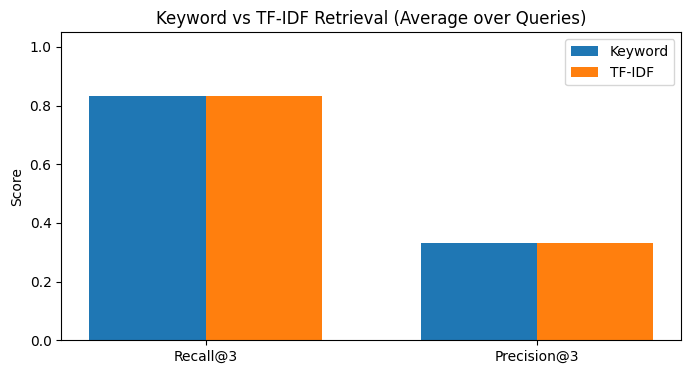

In [7]:
# Simple bar plot to visualize average metrics
avg_kw_recall = comparison["kw_recall@3"].mean()
avg_tf_recall = comparison["tfidf_recall@3"].mean()
avg_kw_prec = comparison["kw_precision@3"].mean()
avg_tf_prec = comparison["tfidf_precision@3"].mean()

metrics = ["Recall@3", "Precision@3"]
kw_scores = [avg_kw_recall, avg_kw_prec]
tf_scores = [avg_tf_recall, avg_tf_prec]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, kw_scores, width, label="Keyword")
plt.bar(x + width/2, tf_scores, width, label="TF-IDF")

plt.xticks(x, metrics)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Keyword vs TF-IDF Retrieval (Average over Queries)")
plt.legend()
plt.show()

## 5. Answer Quality: A Simple Overlap Metric

Once retrieval is working, we also care about **how good the answers are**.

In production, people use more advanced metrics like:

- **BLEU / ROUGE / METEOR** → compare wording and phrasing
- **BERTScore / MoverScore** → compare meaning using embeddings
- **LLM-as-a-judge** → A powerful LLM scores the answer on a 1–10 scale

For this tutorial, we’ll use a **super simple metric**:

> **“What fraction of important words in the gold answer also appear in the model’s answer?”**

This is **NOT** a production-grade metric, but it is:

- Easy to understand
- Easy to implement
- A good starting point to think about “answer overlap” and “coverage”


In [8]:
import string

STOPWORDS = {
    "the", "a", "an", "is", "are", "of", "and", "or", "to", "in", "on",
    "for", "with", "that", "this", "it", "as", "by", "be"
}

def normalize_text(text: str) -> List[str]:
    """Lowercase, remove punctuation, split into words, drop stopwords."""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens


def overlap_score(gold: str, pred: str) -> float:
    """Fraction of gold words that appear in the predicted answer.
    
    score = |gold_words ∩ pred_words| / |gold_words|
    """
    gold_tokens = set(normalize_text(gold))
    pred_tokens = set(normalize_text(pred))
    if not gold_tokens:
        return 0.0
    overlap = gold_tokens & pred_tokens
    return len(overlap) / len(gold_tokens)


# Demo on our tiny set
rows = []
for qi in range(len(queries)):
    gold = gold_answers[qi]
    pred = model_answers[qi]
    score = overlap_score(gold, pred)
    rows.append({
        "query_id": qi,
        "query": queries[qi],
        "gold_answer": gold,
        "model_answer": pred,
        "overlap_score": score,
    })

pd.DataFrame(rows)[["query_id", "overlap_score"]]

,query_id,overlap_score
0,0,0.166667
1,1,0.166667
2,2,0.384615


### 5.1 Inspecting One Example

Let’s look at the **RAG** question and see which words overlap between the gold and model answers.


In [9]:
example_q = 0
gold = gold_answers[example_q]
pred = model_answers[example_q]

print("QUESTION:")
print(queries[example_q])
print("\nGOLD ANSWER:")
print(gold)
print("\nMODEL ANSWER:")
print(pred)

gold_tokens = set(normalize_text(gold))
pred_tokens = set(normalize_text(pred))
print("\nImportant words in gold answer:", gold_tokens)
print("Words used by model:", pred_tokens)
print("Overlap:", gold_tokens & pred_tokens)
print("Overlap score:", overlap_score(gold, pred))

QUESTION:
How do RAG systems work?

GOLD ANSWER:
A RAG system retrieves relevant documents and feeds them into an LLM to generate grounded answers.

MODEL ANSWER:
RAG uses search plus a language model. It looks up context and then the LLM uses it to answer.

Important words in gold answer: {'grounded', 'into', 'documents', 'them', 'generate', 'answers', 'rag', 'feeds', 'llm', 'retrieves', 'system', 'relevant'}
Words used by model: {'context', 'rag', 'plus', 'looks', 'search', 'model', 'up', 'llm', 'answer', 'then', 'language', 'uses'}
Overlap: {'rag', 'llm'}
Overlap score: 0.16666666666666666


## 6. Summary & Next Steps

In this notebook, you learned how to:

1. **Build a tiny retrieval dataset** with documents, queries, and ground-truth relevance.
2. Implement **Recall@k** and **Precision@k** to measure retrieval quality.
3. Compare a simple **keyword overlap retriever** to a classic **TF‑IDF + cosine similarity** retriever.
4. Compute a **simple answer-overlap score** to get a first signal of answer quality.

### Where to go next

- Swap TF‑IDF for **embeddings** (e.g., OpenAI, SentenceTransformers) and re-run the same metrics.
- Replace the simple overlap score with:
  - ROUGE or BERTScore
  - LLM-as-a-judge scoring (e.g., GPT comparing two answers)
- Log real **user queries + feedback** and treat this notebook as a template for your own evaluation stack.

> 🧩 **Key idea:** RAG / LLM evaluation is not magic.  
> It’s mostly about **clearly defining what “good” means**, then turning that into **measurable metrics** you can compute and track.


## Advanced Evaluation Metrics (Beginner Overview)

### **BLEU, ROUGE, METEOR — Text Overlap Metrics**
- BLEU → used in machine translation
- ROUGE → used in summarization
- METEOR → considers synonyms + ordering

**Beginner intuition:** These metrics detect *how much wording is shared* between prediction and reference.

---
### **BERTScore, MoverScore — Semantic Similarity Metrics**
- Use embeddings to measure *meaning*, not exact words
- Much better for paraphrased answers

**Beginner intuition:** Even if words differ, these metrics ask: *Do the answers mean the same thing?*

---
### **LLM‑as‑a‑Judge — Model‑Graded Evaluation**
A large model (GPT‑4, GPT‑5, etc.) evaluates an answer.

Example prompt:
> “Score this answer from 1–10 based on correctness and helpfulness.”

**Beginner intuition:** Instead of rigid text rules, we ask a model to evaluate like a human.


In [11]:
import re

def simple_overlap(reference: str, prediction: str) -> float:
    """
    Simple text‑overlap metric for beginners.
    Extracts meaningful words and measures how many appear in both.
    """
    ref_words = set(re.findall(r"[a-zA-Z]+", reference.lower()))
    pred_words = set(re.findall(r"[a-zA-Z]+", prediction.lower()))

    if not ref_words:
        return 0.0

    overlap = ref_words.intersection(pred_words)
    return len(overlap) / len(ref_words)

# Example
ref = "Paris is the capital of France."
pred = "The capital city of France is Paris."
print(simple_overlap(ref, pred))

1.0
